# Evaluating model and interpret the classification results

In [1]:
import torchray
import torch
import attr
from pathlib import Path
from torchvision import datasets, transforms
from torchray.benchmark import get_example_data, plot_example
from torchvision import models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as sk_metrics
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency
from PIL import Image

In [2]:
@attr.s(auto_attribs=True)
class DataPreparation:
    data_dir: Path
    device: str = attr.ib(default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), init=False)

    @staticmethod
    def data_transformations():
        data_transforms = {
            'test': transforms.Compose([
                transforms.CenterCrop((200, 1500)),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return data_transforms
    
    def create_dataloaders(self, batch_size, shuffle, num_workers):
        data_transforms = self.data_transformations()
        
        image_datasets = {
            'test': datasets.ImageFolder(self.data_dir, data_transforms['test'])
        }
        dataloaders = {
            'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        }
        dataset_sizes = {
            'test': len(image_datasets['test'])
        }
        return dataloaders, dataset_sizes


In [3]:
data_prep = DataPreparation('../data/figures/test')
data, size = data_prep.create_dataloaders(16, False, 4)

In [4]:
# CHECK THIS!!!
beat = "mid"

In [5]:
model_path = Path().cwd().parents[0] / f"models/resnet50_d_02_t_22_52_{beat}_beat.pth"
model = torch.load(model_path)
model.eval();

In [6]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [7]:
i = 0
for inputs, labels in data['test']:
    inputs = inputs.to(0)
    labels = labels.to(0)
    x = inputs
    break
    x.requires_grad_();
    scores = model(x)
    score_max_index = scores.argmax(dim=1)
    score_max = scores[:, score_max_index]
    score_max.backward(torch.ones_like(score_max))
    saliency, _ = torch.max(x.grad.data.abs(),dim=1)
    
    for index in range(len(saliency)): 
        plt.figure()
        img1 = plt.imshow(saliency[index].cpu().numpy(), cmap=plt.cm.hot, alpha=.7);
        img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4);
        plt.axis('off')
        if labels[index] == 0:
            label = "abnormal"
        else:
            label = "normal"
        ### CHANGE NAME!!!!!!!
        plt.savefig(f"../saliency_maps/label_{beat}_beat/{label}/{i}_{index}.png")
        plt.close()
        
    i += 1

In [8]:
x.size()

torch.Size([16, 3, 224, 224])

In [ ]:
x.requires_grad_();
scores = model(x)

In [ ]:
print(f"Scores\tLabels\n{scores}\t{labels}")

In [ ]:
score_max_index = scores.argmax(dim=1)
print(f"SCORE MAX INDEX: {score_max_index}")
score_max = scores[:, score_max_index]
print(f"SCORE MAX: {score_max}")

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward(torch.ones_like(score_max))
# score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(x.grad.data.abs(),dim=1)

In [ ]:
index = 3
# code to plot the saliency map as a heatmap
plt.figure()
img1 = plt.imshow(saliency[index].cpu().numpy(), cmap=plt.cm.hot, alpha=.7)
# plt.axis('off')
# plt.show()
img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4)
plt.axis('off')
plt.show()

In [ ]:
x[index].detach().cpu().numpy().shape

In [ ]:
x_img = deprocess(x[index].cpu())
np.transpose(x[index].detach().cpu().numpy(), (1,2,0)).shape

In [ ]:
sal = saliency[index].cpu().numpy()

In [ ]:
saliency_arr = np.array([sal, sal, sal])
saliency_arr.shape

In [ ]:
map_sal = Image.fromarray(saliency_arr.T, 'RGB')

In [ ]:
map_sal.size, x_img.size

In [ ]:
newimg1 = Image.blend(x_img, map_sal, alpha=0.5)

In [ ]:
newimg1.save('example.png', 'png')

In [ ]:
deprocess(x[index].cpu()).save("test.png")

In [ ]:
saliency[index].mean()

In [ ]:
img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4)
plt.axis('off')
plt.show()

-------------------------------------------------------------------------------------------------

# Grad CAM

In [9]:
saliency_layer = get_module(model, model.layer4)
probe = Probe(saliency_layer, target='output')
y = model(x)
score_max_index = y.argmax(dim=1)
z = y[:, score_max_index]
z.backward(torch.ones_like(z))

torch.Size([16, 2048, 7, 7])


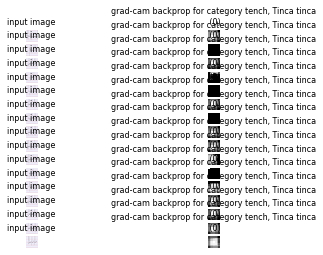

In [10]:
print(probe.data[0].size())
saliency = gradient_to_grad_cam_saliency(probe.data[0])
# Plots.
plot_example(x, saliency, 'grad-cam backprop', labels, save_path='saliency.pdf')

In [11]:
saliency.size()

torch.Size([16, 1, 7, 7])

In [12]:
index = 2

In [16]:
import cv2
heatmap = np.float32(saliency[index, 0].cpu().detach())
img = np.float32(x[index].cpu().detach().numpy())
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(cv2.UMat(heatmap), cv2.COLORMAP_JET)
print(type(heatmap))
# superimposed_img = heatmap * 0.4 + img
superimposed_img = cv2.addWeighted(img, .4, heatmap, .4, 0)
cv2.imwrite('./map.jpg', superimposed_img)

<class 'cv2.UMat'>


error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\core\src\arithm.cpp:663: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


--------------------------------------------------------------

# Perturbation Maps

In [26]:
from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchray.utils import get_device

extremal_perturbation:
- target: 0
- areas: [0.08]
- variant: preserve
- max_iter: 800
- step/sigma: 7, 21
- image size: [1, 3, 224, 224]
- reward function: contrastive_reward
- Perturbation:
  - type: blur
  - num_levels: 8
  - pyramid shape: [8, 3, 224, 224]
- mask resolution:
  torch.Size([1, 1, 32, 32])
[0001/0800] [area:0.08 loss:-2.25 reg:-254.14]


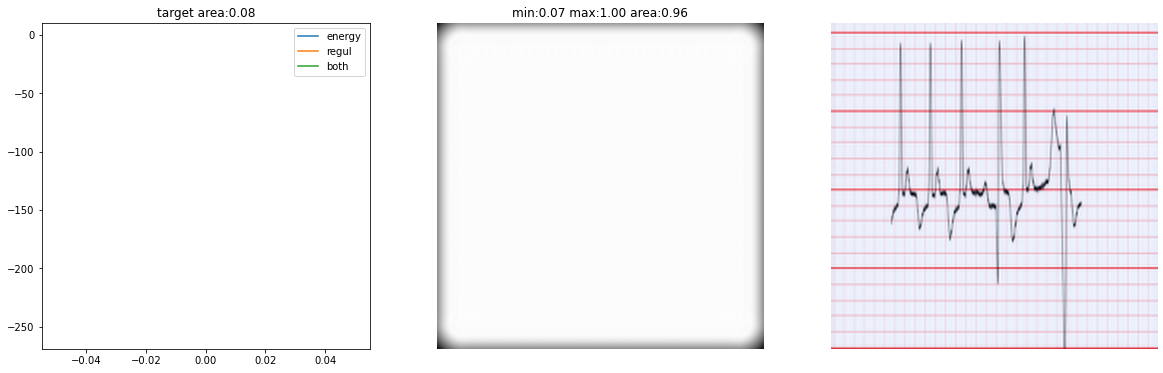

[0200/0800] [area:0.08 loss:-2.41 reg:-24.77]


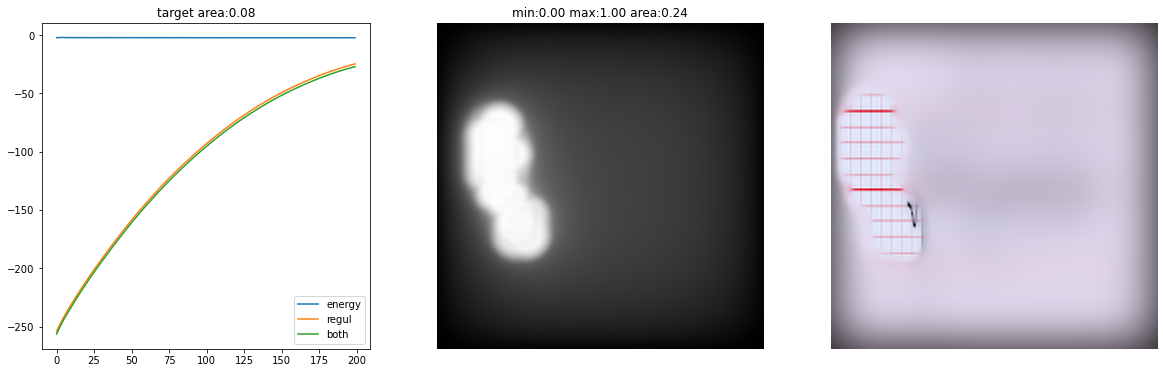

[0399/0800] [area:0.08 loss:-2.28 reg:-8.87]


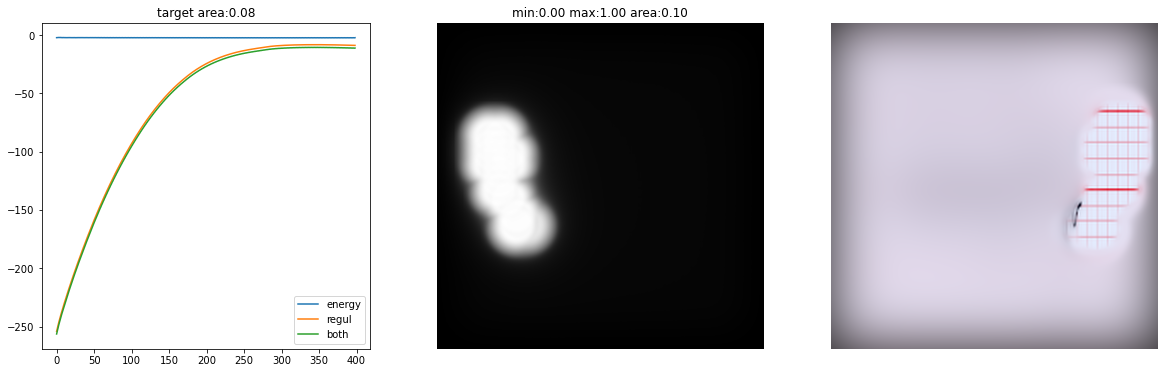

[0598/0800] [area:0.08 loss:-2.42 reg:-15.23]


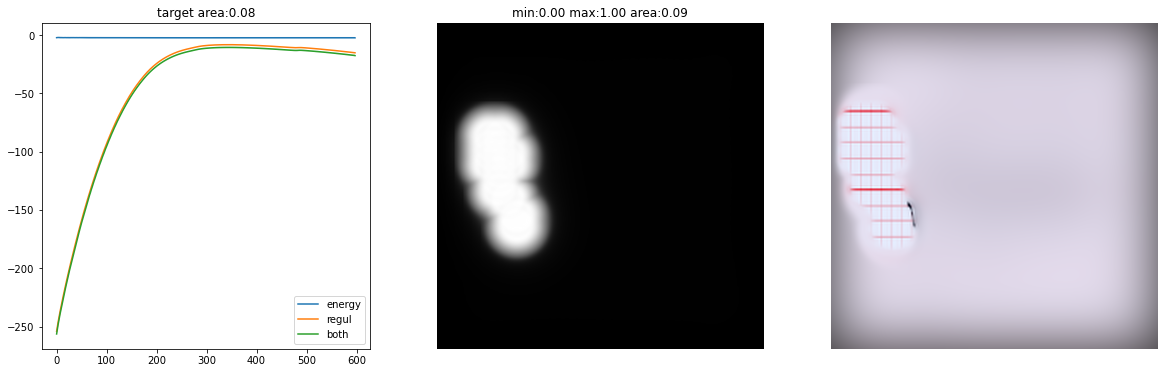

[0797/0800] [area:0.08 loss:-2.27 reg:-30.40]


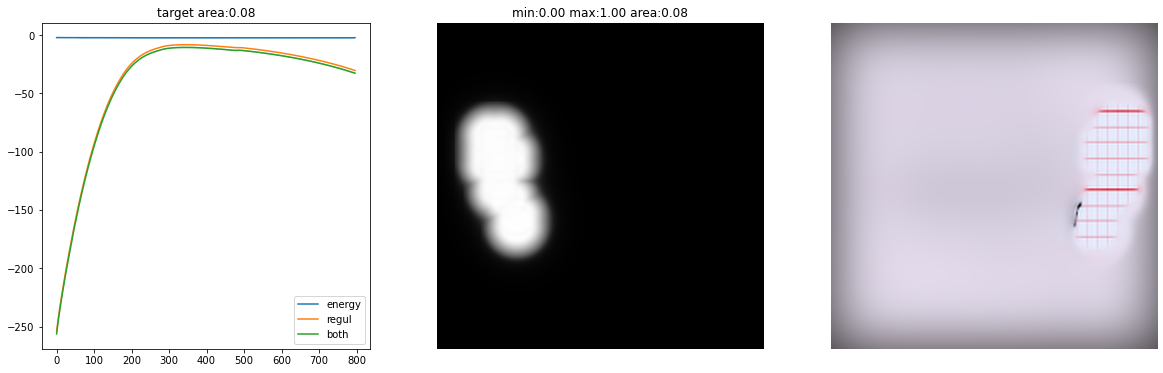

[0800/0800] [area:0.08 loss:-2.42 reg:-30.72]


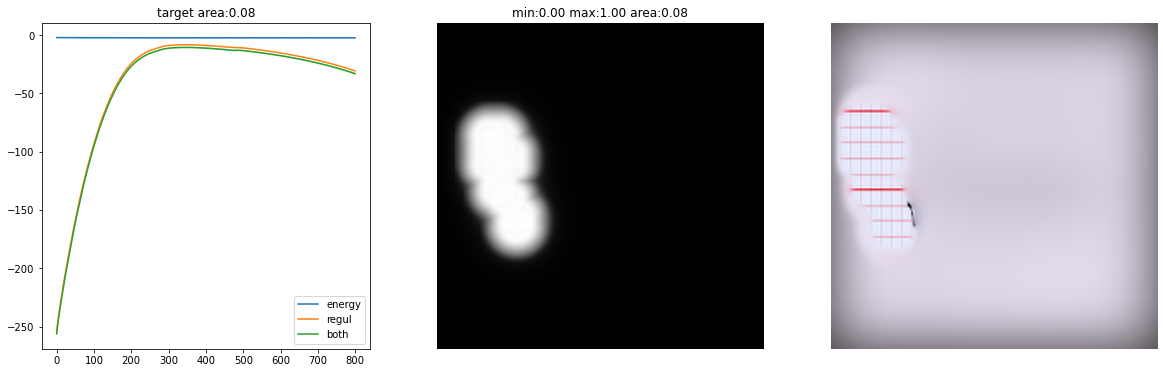

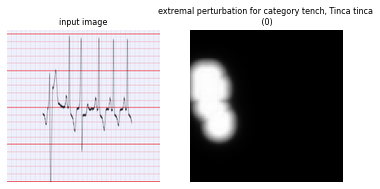

In [27]:
# Extremal perturbation backprop.
index = 1
masks_1, _ = extremal_perturbation(
    model, x[index].unsqueeze(0), labels[index].int().item(),
    reward_func=contrastive_reward,
    debug=True, areas=[.08],
    perturbation="blur"
)

# Plots.
plot_example(x[index].unsqueeze(0), masks_1, 'extremal perturbation', labels[index].int().item())

----------------------------------------------------

# BagNets

In [28]:
from bagnets.utils import plot_heatmap, generate_heatmap_pytorch

In [29]:
index=1

In [30]:
import bagnets.pytorchnet
pytorch_model = bagnets.pytorchnet.bagnet9(pretrained=True).cuda()
pytorch_model.eval();

In [31]:
original, label = x[index].unsqueeze(0).detach().cpu().numpy(), labels[index].unsqueeze(0)
heatmap = generate_heatmap_pytorch(model, original, labels[index].unsqueeze(0), patchsize=33)
# heatmap = generate_heatmap_pytorch(pytorch_model, original, label, patchsize=9)

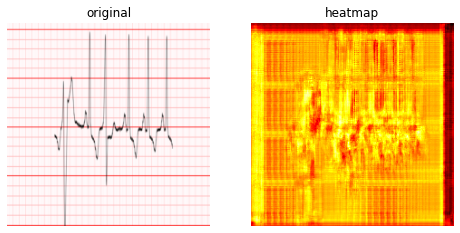

In [32]:
fig = plt.figure(figsize=(8, 4))

ax = plt.subplot(121)
ax.set_title('original')
plt.imshow(deprocess(x[index].detach().cpu()))
plt.axis('off')

ax = plt.subplot(122)
ax.set_title('heatmap')
plt.imshow(heatmap, cmap='hot')

# plot_heatmap(heatmap, original_image, ax, cmap='hot', dilation=0.5, percentile=99, alpha=.25)
plt.axis('off')

plt.show()

------------------------------------------------

# CXPlain

https://github.com/d909b/cxplain

-------------------------------------------

# Grad CAM
https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

In [42]:
scores

tensor([[ 1.2025, -1.2016],
        [-1.1010,  1.1019],
        [ 1.6741, -1.6731],
        [-0.3625,  0.3634],
        [-1.1372,  1.1382],
        [ 1.4850, -1.4841],
        [-1.1765,  1.1774],
        [ 1.4717, -1.4708],
        [ 1.4061, -1.4052],
        [ 0.6963, -0.6954],
        [-0.9947,  0.9956],
        [ 0.7474, -0.7464],
        [ 1.4196, -1.4186],
        [ 1.6541, -1.6532],
        [ 1.4421, -1.4412],
        [ 1.3862, -1.3852]], device='cuda:0', grad_fn=<AddmmBackward>)

In [45]:
# pull the gradients out of the model
gradients = model.

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(x[index]).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

ModuleAttributeError: 'ResNet' object has no attribute 'gradients'